In [1]:
# set the environment of the game
import gym
import numpy as np
import tensorflow as tf
print(tf.__version__)

import random
from collections import deque
import matplotlib.pyplot as plt
import time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     #os.environ['CUDA_VISIBLE_DEVICES'] = '7'

1.15.3


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [180]:
# set the environment of the game
env = gym.make('CartPole-v0')


In [48]:
# set up the training hyperparameters

state_size = 4 # our input is an observation with four elements
action_size = env.action_space.n  # number of actions (push to left or push to right)
possible_actions = np.identity(2, dtype = int).tolist()


# training hyperparameters
learning_rate = 0.001

number_epoch = 500 # number of epochs for training
batch_size = 1000 # defines number of samples work though

training = True 
hidden_size_1 = 53
hidden_size_2 = 34

max_steps = 200 # Max steps per episode



In [32]:
# calculate the discounted some of reward from current step onward
def discount_rewards(r, gamma = 0.95, constant_baseline = False):
    discounted_r = np.zeros_like(r) #make a vector of zeros with the size of input
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    if constant_baseline: # do normalization for reward to have more smooth gradient
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean)/(std)
        
    return discounted_r 


In [50]:
# define the policy network 

class PGNetwork():
    def __init__(self, state_size, action_size, learning_rate, hidden_size_1, hidden_size_2, name = 'PGNetwork'):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, state_size], name = 'inputs')
                self.actions = tf.placeholder(tf.int32, shape = [None, action_size], name = 'actions')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            
            # CNN is often used for image process, because here we are not dealing with image, we use general fully connected layers
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the hidden nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       

            with tf.name_scope('layer2'):
                # filters gives the number of filters in the hidden nn
                self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
                                             num_outputs = self.hidden_size_2,   
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())

 
            with tf.name_scope('logits'):
                # get the action distribution from the fully connected NN
                self.logits = tf.layers.dense(inputs = self.layer2,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.action_size, 
                                             activation = None)
                
            with tf.name_scope('softmax'):
                self.action_distribution = tf.nn.softmax(self.logits)
                
            # define the loss function
            with tf.name_scope('loss'):
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.actions)
                #self.log_action_probability = tf.nn.softmax_cross_entropy_with_logits(logits = self.outputlayer, labels = self.actions)
                self.weighted_likelihoods = tf.multiply(self.cross_entropy, self.discounted_episode_rewards)
                self.loss = tf.reduce_mean(self.weighted_likelihoods)
                
            with tf.name_scope('train'):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate,  beta1=0.9, beta2=0.99)
                self.train_opt = self.optimizer.minimize(self.loss)
            
            

In [51]:
# Value estimator network
class VENetwork():
    def __init__(self, state_size, learning_rate,  name = 'VENetwork'):
        
        self.state_size = state_size
        self.output_size = 1
        self.learning_rate = learning_rate
        self.hidden_size_1 = 16
        #self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, state_size], name = 'inputs')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            
            # CNN is often used for image process, because here we are not dealing with image, we use general fully connected layers
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the convolution nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       
            
            #with tf.name_scope('layer2'):
                # filters gives the number of filters in the convolution nn
            #    self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
            #                                 num_outputs = self.hidden_size_2,   
            #                                 activation_fn = tf.nn.elu,
            #                                 weights_initializer=tf.contrib.layers.xavier_initializer())
                
             
            with tf.name_scope('output'):
                # get the action distribution from the fully connected NN
                self.output_layer = tf.layers.dense(inputs = self.layer1,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.output_size, 
                                             activation = None)
                
                self.state_value_estimation = tf.squeeze(self.output_layer)
                
            # define the loss function
            with tf.name_scope('loss'):

                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards))
                
            with tf.name_scope('train'):
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)

In [52]:
# sample from the environment 
# initialize network and session
tf.reset_default_graph()
PGN = PGNetwork(state_size, action_size, learning_rate, hidden_size_1, hidden_size_2)
VEN = VENetwork(state_size, learning_rate)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [53]:
# run the policy until it reached maximum batch number and outputs information of each step (batch number)
# for each episode
def make_batch(batch_size):
    states, actions, rewards_of_episode, rewards_of_batch,rewards_of_episode0, discounted_rewards = [],[],[],[],[],[]
    # keep track of how many episodes in our batch (useful when we need to calculate the average reward)
    episode_num = 1
    # get a new state
    state = env.reset()
   
    while True:
        
        action_probability_distribution = sess.run(PGN.action_distribution, feed_dict = {PGN.inputs: state.reshape(1, state_size)})
        state_value_estimation = sess.run(VEN.state_value_estimation, feed_dict = {VEN.inputs: state.reshape(1, state_size)})
        action = np.random.choice(range(action_probability_distribution.shape[1]), p = action_probability_distribution.ravel())
        next_state, reward, done, info = env.step(action)
        
        action_ = [0,0]
        action_[action] = 1
        
        states.append(state)
        actions.append(action_)
        rewards_of_episode.append(reward)
        rewards_of_episode0.append(reward-state_value_estimation)

        if done:
            rewards_of_batch.append(rewards_of_episode)
    
            discounted_rewards.append(discount_rewards(rewards_of_episode0, gamma = 0.95, constant_baseline = True))
            
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            rewards_of_episode = []
            rewards_of_episode0 = []
            episode_num +=1
            
            state = env.reset()
        else:
            state = next_state

    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num


In [54]:
# training and print sth
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
average_reward = []
epoch = 1
# for plotting
epoch_1 = []
average_reward = []
saver = tf.train.Saver()
# while we have epoch/episode to train

if training:
    # number of iterations
    while epoch < number_epoch +1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size)
   
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        print('check',rewards_of_batch.shape, np.array(total_reward_of_that_batch).shape)
        allRewards.append(total_reward_of_that_batch)
        
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)
        maximumRewardRecorded = np.amax(allRewards)
        print('epoch',epoch)
        epoch_1.append(epoch)
        print('====================================')
        print("Epoch: ", epoch, '/', number_epoch)
        print('------------')
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward:{}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        loss_, cross, _= sess.run([PGN.loss, PGN.cross_entropy, PGN.train_opt],feed_dict = {PGN.inputs: states_mb.reshape([len(states_mb), state_size]), PGN.actions: actions_mb,PGN.discounted_episode_rewards: discounted_rewards_mb})    
        loss_VE, _= sess.run([VEN.loss, VEN.train_opt],feed_dict = {VEN.inputs: states_mb.reshape([len(states_mb), state_size]), VEN.discounted_episode_rewards: discounted_rewards_mb})    

        print('check',total_reward_of_that_batch)
        print('Training loss:{}'.format(loss_) )
        print('Cross Entropy:{}'.format(cross) )
        print('VE Training loss:{}'.format(loss_VE) )
              
        if epoch % 10 == 0:
              saver.save(sess, "./models/model.ckpt")
              print('Model saved')
        epoch += 1
        average_reward.append(mean_reward_of_that_batch)

check (1028,) ()
epoch 1
Epoch:  1 / 500
------------
Number of training episodes: 41
Total reward:1028.0
Mean Reward of that batch 25.073170731707318
Average Reward of all training: 25.073170731707318
Max reward for a batch so far: 1028.0
check 1028.0
Training loss:0.0067292326129972935
Cross Entropy:[0.6949106  0.71694565 0.69459105 ... 0.7402917  0.67389506 0.642808  ]
VE Training loss:1.0363086462020874
check (1002,) ()
epoch 2
Epoch:  2 / 500
------------
Number of training episodes: 43
Total reward:1002.0
Mean Reward of that batch 23.302325581395348
Average Reward of all training: 24.187748156551333
Max reward for a batch so far: 1028.0
check 1002.0
Training loss:-0.0003793962823692709
Cross Entropy:[0.6999422  0.6911365  0.67745197 ... 0.64025176 0.77001095 0.6368575 ]
VE Training loss:1.072463870048523
check (1011,) ()
epoch 3
Epoch:  3 / 500
------------
Number of training episodes: 48
Total reward:1011.0
Mean Reward of that batch 21.0625
Average Reward of all training: 23.145

check (1043,) ()
epoch 20
Epoch:  20 / 500
------------
Number of training episodes: 21
Total reward:1043.0
Mean Reward of that batch 49.666666666666664
Average Reward of all training: 34.14952092246762
Max reward for a batch so far: 1093.0
check 1043.0
Training loss:-0.0027646103408187628
Cross Entropy:[0.58640707 0.5555722  0.59223884 ... 0.76034594 1.1122868  1.5080118 ]
VE Training loss:1.0403532981872559
Model saved
check (1055,) ()
epoch 21
Epoch:  21 / 500
------------
Number of training episodes: 23
Total reward:1055.0
Mean Reward of that batch 45.869565217391305
Average Reward of all training: 34.707618269844936
Max reward for a batch so far: 1093.0
check 1055.0
Training loss:-0.0026362822391092777
Cross Entropy:[0.5280139  0.61956453 0.5116076  ... 0.46530277 0.74461997 0.39985812]
VE Training loss:1.1169158220291138
check (1024,) ()
epoch 22
Epoch:  22 / 500
------------
Number of training episodes: 23
Total reward:1024.0
Mean Reward of that batch 44.52173913043478
Average R

check (1169,) ()
epoch 39
Epoch:  39 / 500
------------
Number of training episodes: 11
Total reward:1169.0
Mean Reward of that batch 106.27272727272727
Average Reward of all training: 57.021449926653915
Max reward for a batch so far: 1169.0
check 1169.0
Training loss:-0.02011018991470337
Cross Entropy:[0.69413507 1.1257586  0.2180802  ... 0.11261839 1.9308714  0.0835974 ]
VE Training loss:1.083898901939392
check (1046,) ()
epoch 40
Epoch:  40 / 500
------------
Number of training episodes: 9
Total reward:1046.0
Mean Reward of that batch 116.22222222222223
Average Reward of all training: 58.501469234043135
Max reward for a batch so far: 1169.0
check 1046.0
Training loss:-0.030573656782507896
Cross Entropy:[0.7390274 1.1778281 0.2090649 ... 0.4119439 0.6231837 0.9098507]
VE Training loss:1.0924530029296875
Model saved
check (1146,) ()
epoch 41
Epoch:  41 / 500
------------
Number of training episodes: 9
Total reward:1146.0
Mean Reward of that batch 127.33333333333333
Average Reward of a

check (1014,) ()
epoch 58
Epoch:  58 / 500
------------
Number of training episodes: 6
Total reward:1014.0
Mean Reward of that batch 169.0
Average Reward of all training: 85.9897584755853
Max reward for a batch so far: 1169.0
check 1014.0
Training loss:-0.013449572958052158
Cross Entropy:[0.74079406 1.4036249  0.11906946 ... 0.74270093 0.28399792 0.5489378 ]
VE Training loss:1.0092222690582275
check (1128,) ()
epoch 59
Epoch:  59 / 500
------------
Number of training episodes: 8
Total reward:1128.0
Mean Reward of that batch 141.0
Average Reward of all training: 86.9221354505754
Max reward for a batch so far: 1169.0
check 1128.0
Training loss:-0.023851288482546806
Cross Entropy:[0.76364595 0.25603956 0.5633168  ... 0.10807535 0.19080973 1.2718754 ]
VE Training loss:1.007515549659729
check (1143,) ()
epoch 60
Epoch:  60 / 500
------------
Number of training episodes: 7
Total reward:1143.0
Mean Reward of that batch 163.28571428571428
Average Reward of all training: 88.19486176449438
Max r

check (1072,) ()
epoch 77
Epoch:  77 / 500
------------
Number of training episodes: 6
Total reward:1072.0
Mean Reward of that batch 178.66666666666666
Average Reward of all training: 107.228525555512
Max reward for a batch so far: 1169.0
check 1072.0
Training loss:-0.0005435610073618591
Cross Entropy:[0.7378892 1.5360596 0.087049  ... 0.5872363 0.298734  0.6922266]
VE Training loss:0.9872849583625793
check (1155,) ()
epoch 78
Epoch:  78 / 500
------------
Number of training episodes: 6
Total reward:1155.0
Mean Reward of that batch 192.5
Average Reward of all training: 108.32174958685158
Max reward for a batch so far: 1169.0
check 1155.0
Training loss:-0.00393707025796175
Cross Entropy:[0.75123614 1.4909959  0.09979896 ... 0.05738474 0.1218955  0.2663347 ]
VE Training loss:1.0344771146774292
check (1142,) ()
epoch 79
Epoch:  79 / 500
------------
Number of training episodes: 6
Total reward:1142.0
Mean Reward of that batch 190.33333333333334
Average Reward of all training: 109.359870900

check (1200,) ()
epoch 96
Epoch:  96 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 122.55036003138041
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004714453127235174
Cross Entropy:[0.8007611  0.19712652 0.89312476 ... 0.9375659  0.16374955 1.138126  ]
VE Training loss:0.9822216033935547
check (1008,) ()
epoch 97
Epoch:  97 / 500
------------
Number of training episodes: 6
Total reward:1008.0
Mean Reward of that batch 168.0
Average Reward of all training: 123.01891302074762
Max reward for a batch so far: 1200.0
check 1008.0
Training loss:-0.010838034562766552
Cross Entropy:[0.6284267  0.285923   0.7959713  ... 0.7400355  0.24963526 0.6480371 ]
VE Training loss:0.9047507047653198
check (1150,) ()
epoch 98
Epoch:  98 / 500
------------
Number of training episodes: 6
Total reward:1150.0
Mean Reward of that batch 191.66666666666666
Average Reward of all training: 123.71940030284883


check (1109,) ()
epoch 115
Epoch:  115 / 500
------------
Number of training episodes: 6
Total reward:1109.0
Mean Reward of that batch 184.83333333333334
Average Reward of all training: 133.45363388126827
Max reward for a batch so far: 1200.0
check 1109.0
Training loss:1.7762937204679474e-05
Cross Entropy:[0.7106867  0.22408581 0.6464306  ... 0.15821901 1.2752908  0.09046236]
VE Training loss:0.9598700404167175
check (1160,) ()
epoch 116
Epoch:  116 / 500
------------
Number of training episodes: 6
Total reward:1160.0
Mean Reward of that batch 193.33333333333334
Average Reward of all training: 133.96983818688955
Max reward for a batch so far: 1200.0
check 1160.0
Training loss:-0.001948269084095955
Cross Entropy:[0.6735107  0.24549735 0.65495044 ... 0.11383701 1.479311   2.7974143 ]
VE Training loss:0.9562765955924988
check (1131,) ()
epoch 117
Epoch:  117 / 500
------------
Number of training episodes: 6
Total reward:1131.0
Mean Reward of that batch 188.5
Average Reward of all training

check (1132,) ()
epoch 134
Epoch:  134 / 500
------------
Number of training episodes: 6
Total reward:1132.0
Mean Reward of that batch 188.66666666666666
Average Reward of all training: 142.3519992264616
Max reward for a batch so far: 1200.0
check 1132.0
Training loss:-0.025910843163728714
Cross Entropy:[0.82326186 0.19652134 0.5859445  ... 0.05998826 0.15297028 1.1246465 ]
VE Training loss:0.9691994786262512
check (1174,) ()
epoch 135
Epoch:  135 / 500
------------
Number of training episodes: 6
Total reward:1174.0
Mean Reward of that batch 195.66666666666666
Average Reward of all training: 142.7469226889816
Max reward for a batch so far: 1200.0
check 1174.0
Training loss:0.009621607139706612
Cross Entropy:[0.6775753  0.24802558 0.7352384  ... 0.12078979 1.1937082  0.12394488]
VE Training loss:0.9659517407417297
check (1200,) ()
epoch 136
Epoch:  136 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 14

check (1174,) ()
epoch 153
Epoch:  153 / 500
------------
Number of training episodes: 6
Total reward:1174.0
Mean Reward of that batch 195.66666666666666
Average Reward of all training: 148.908504769145
Max reward for a batch so far: 1200.0
check 1174.0
Training loss:-0.02022477053105831
Cross Entropy:[0.77927756 0.19377455 0.8176161  ... 0.53197896 0.29168996 0.6494969 ]
VE Training loss:0.9571539163589478
check (1179,) ()
epoch 154
Epoch:  154 / 500
------------
Number of training episodes: 6
Total reward:1179.0
Mean Reward of that batch 196.5
Average Reward of all training: 149.21754045246226
Max reward for a batch so far: 1200.0
check 1179.0
Training loss:-0.006249654106795788
Cross Entropy:[0.5663532  0.2997517  0.5212433  ... 0.40311927 0.99748117 1.9214089 ]
VE Training loss:0.9487678408622742
check (1154,) ()
epoch 155
Epoch:  155 / 500
------------
Number of training episodes: 6
Total reward:1154.0
Mean Reward of that batch 192.33333333333334
Average Reward of all training: 14

check (1076,) ()
epoch 172
Epoch:  172 / 500
------------
Number of training episodes: 6
Total reward:1076.0
Mean Reward of that batch 179.33333333333334
Average Reward of all training: 153.71318544387123
Max reward for a batch so far: 1200.0
check 1076.0
Training loss:-0.003270538290962577
Cross Entropy:[0.5203339  0.29378664 0.86797976 ... 0.14518872 1.0525761  0.14655045]
VE Training loss:0.9186097979545593
check (1062,) ()
epoch 173
Epoch:  173 / 500
------------
Number of training episodes: 6
Total reward:1062.0
Mean Reward of that batch 177.0
Average Reward of all training: 153.84779130835753
Max reward for a batch so far: 1200.0
check 1062.0
Training loss:0.012011063285171986
Cross Entropy:[0.7459697  0.20223421 0.6503798  ... 0.41314057 0.89540243 0.2167224 ]
VE Training loss:0.940028727054596
check (1121,) ()
epoch 174
Epoch:  174 / 500
------------
Number of training episodes: 6
Total reward:1121.0
Mean Reward of that batch 186.83333333333334
Average Reward of all training: 1

check (1144,) ()
epoch 191
Epoch:  191 / 500
------------
Number of training episodes: 6
Total reward:1144.0
Mean Reward of that batch 190.66666666666666
Average Reward of all training: 156.95899422170604
Max reward for a batch so far: 1200.0
check 1144.0
Training loss:-0.0028214554768055677
Cross Entropy:[0.61974615 0.24710989 0.59379023 ... 1.0579131  0.12846322 1.2210128 ]
VE Training loss:0.9285492897033691
check (1181,) ()
epoch 192
Epoch:  192 / 500
------------
Number of training episodes: 6
Total reward:1181.0
Mean Reward of that batch 196.83333333333334
Average Reward of all training: 157.16667307124575
Max reward for a batch so far: 1200.0
check 1181.0
Training loss:0.0007132324972189963
Cross Entropy:[0.5885524  0.25078857 0.6090099  ... 0.2614068  0.63253623 0.2718841 ]
VE Training loss:0.981525719165802
check (1168,) ()
epoch 193
Epoch:  193 / 500
------------
Number of training episodes: 6
Total reward:1168.0
Mean Reward of that batch 194.66666666666666
Average Reward of 

check (1184,) ()
epoch 210
Epoch:  210 / 500
------------
Number of training episodes: 6
Total reward:1184.0
Mean Reward of that batch 197.33333333333334
Average Reward of all training: 160.52064077625008
Max reward for a batch so far: 1200.0
check 1184.0
Training loss:-0.004868335090577602
Cross Entropy:[0.75998676 1.6496638  0.06916384 ... 1.1146573  0.09892675 1.6232429 ]
VE Training loss:0.9711143970489502
Model saved
check (1200,) ()
epoch 211
Epoch:  211 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 160.70774674413516
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.00675421254709363
Cross Entropy:[0.8561737  0.1691455  0.919852   ... 0.41483006 0.38186666 0.43766946]
VE Training loss:1.0215065479278564
check (1200,) ()
epoch 212
Epoch:  212 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 16

check (1180,) ()
epoch 229
Epoch:  229 / 500
------------
Number of training episodes: 6
Total reward:1180.0
Mean Reward of that batch 196.66666666666666
Average Reward of all training: 163.3136880480896
Max reward for a batch so far: 1200.0
check 1180.0
Training loss:0.012485774233937263
Cross Entropy:[0.6910589  0.21544002 0.7490305  ... 0.3742536  0.41583183 0.56020075]
VE Training loss:0.9530219435691833
check (1164,) ()
epoch 230
Epoch:  230 / 500
------------
Number of training episodes: 6
Total reward:1164.0
Mean Reward of that batch 194.0
Average Reward of all training: 163.44710679570662
Max reward for a batch so far: 1200.0
check 1164.0
Training loss:-0.008193887770175934
Cross Entropy:[0.89338183 0.15326467 0.45949057 ... 0.18489926 0.62229747 0.2353302 ]
VE Training loss:0.9432901740074158
Model saved
check (1175,) ()
epoch 231
Epoch:  231 / 500
------------
Number of training episodes: 6
Total reward:1175.0
Mean Reward of that batch 195.83333333333334
Average Reward of all

check (1200,) ()
epoch 248
Epoch:  248 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 165.8770210874161
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.019271310418844223
Cross Entropy:[0.70500195 0.20107557 0.7260556  ... 1.6246624  0.05459621 0.16785735]
VE Training loss:0.9972675442695618
check (1200,) ()
epoch 249
Epoch:  249 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 166.0140611633702
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.005751046352088451
Cross Entropy:[0.46848983 0.3357164  1.0608981  ... 0.46601075 0.34209624 1.0095166 ]
VE Training loss:1.012027621269226
check (1200,) ()
epoch 250
Epoch:  250 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 166.15000491871672
Max rewar

check (1200,) ()
epoch 267
Epoch:  267 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.15605953687586
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.00366887915879488
Cross Entropy:[0.6950828  0.2007609  0.62130463 ... 0.07284842 0.28240633 0.52356076]
VE Training loss:0.9842110276222229
check (1200,) ()
epoch 268
Epoch:  268 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.27488021024573
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0022394387051463127
Cross Entropy:[0.7708742  0.15891778 0.83327043 ... 0.2583155  0.50551367 0.31176725]
VE Training loss:1.0349596738815308
check (1200,) ()
epoch 269
Epoch:  269 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 168.39281745853478
Max rew

check (1200,) ()
epoch 286
Epoch:  286 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 170.1235474231207
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.003728570183739066
Cross Entropy:[0.65642726 0.20016816 0.67206156 ... 0.23446363 0.8311931  1.9739044 ]
VE Training loss:0.9813210964202881
check (1096,) ()
epoch 287
Epoch:  287 / 500
------------
Number of training episodes: 6
Total reward:1096.0
Mean Reward of that batch 182.66666666666666
Average Reward of all training: 170.16725167135604
Max reward for a batch so far: 1200.0
check 1096.0
Training loss:0.016981318593025208
Cross Entropy:[0.6016152  0.22819307 0.61461985 ... 0.79723704 0.18074073 0.8055097 ]
VE Training loss:0.9863051772117615
check (1200,) ()
epoch 288
Epoch:  288 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 170.27083760305

check (1200,) ()
epoch 305
Epoch:  305 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 171.89344665468585
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0026046722196042538
Cross Entropy:[0.69062    0.22401169 0.7670766  ... 0.11596071 0.3954147  0.38719264]
VE Training loss:0.9749867916107178
check (1200,) ()
epoch 306
Epoch:  306 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 171.98529813620647
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.005780340638011694
Cross Entropy:[0.5235062  0.3406339  0.4818951  ... 1.4476554  0.07237981 0.14388272]
VE Training loss:1.0001882314682007
check (1200,) ()
epoch 307
Epoch:  307 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 172.07655123674002
Max re

check (1125,) ()
epoch 324
Epoch:  324 / 500
------------
Number of training episodes: 6
Total reward:1125.0
Mean Reward of that batch 187.5
Average Reward of all training: 173.2561766348123
Max reward for a batch so far: 1200.0
check 1125.0
Training loss:0.012615768238902092
Cross Entropy:[0.77538145 0.22079103 0.560025   ... 0.32002345 0.65218335 0.2535715 ]
VE Training loss:0.9510459899902344
check (1200,) ()
epoch 325
Epoch:  325 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 173.3384653220898
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.008348347619175911
Cross Entropy:[0.8052609  0.22890534 0.61498713 ... 1.4309262  0.10751367 0.3254831 ]
VE Training loss:0.9893689751625061
check (1200,) ()
epoch 326
Epoch:  326 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 173.42024917079505
Max reward

check (1200,) ()
epoch 343
Epoch:  343 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.52700622286034
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004519718699157238
Cross Entropy:[0.68989533 1.5087637  2.5040486  ... 0.6732346  1.2966617  0.12594414]
VE Training loss:0.9203617572784424
check (1200,) ()
epoch 344
Epoch:  344 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.60105562337526
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.004547474440187216
Cross Entropy:[0.5218447 1.1454923 1.9799428 ... 0.3078931 0.7481061 0.2525732]
VE Training loss:0.9420560598373413
check (1200,) ()
epoch 345
Epoch:  345 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 174.67467575200317
Max reward for

check (1200,) ()
epoch 362
Epoch:  362 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.8234709054542
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.001080106943845749
Cross Entropy:[0.5590471  0.35754752 0.64915955 ... 1.5876428  0.08489294 0.14147447]
VE Training loss:0.9496296048164368
check (1200,) ()
epoch 363
Epoch:  363 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.8900729139791
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.007535476703196764
Cross Entropy:[0.68845856 0.3078575  0.68847287 ... 2.1005445  0.04597885 0.0690725 ]
VE Training loss:0.9432631134986877
check (1200,) ()
epoch 364
Epoch:  364 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 175.95630897740224
Max reward

check (1200,) ()
epoch 381
Epoch:  381 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 176.80733981043156
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.011698850430548191
Cross Entropy:[0.59472847 1.1016847  0.19257784 ... 0.19203444 0.3978257  0.6180343 ]
VE Training loss:0.9443707466125488
check (1128,) ()
epoch 382
Epoch:  382 / 500
------------
Number of training episodes: 6
Total reward:1128.0
Mean Reward of that batch 188.0
Average Reward of all training: 176.83663996799586
Max reward for a batch so far: 1200.0
check 1128.0
Training loss:0.009476106613874435
Cross Entropy:[0.4070606  0.5967596  1.1024557  ... 0.28862214 0.9518056  0.24187551]
VE Training loss:0.9454041719436646
check (1099,) ()
epoch 383
Epoch:  383 / 500
------------
Number of training episodes: 6
Total reward:1099.0
Mean Reward of that batch 183.16666666666666
Average Reward of all training: 176.853167452

check (1200,) ()
epoch 400
Epoch:  400 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.37565783610273
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0006319443346001208
Cross Entropy:[0.6516976  0.3935681  0.67606634 ... 0.32965788 0.59045005 0.46019083]
VE Training loss:0.9561377763748169
Model saved
check (1200,) ()
epoch 401
Epoch:  401 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.43207764199772
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.007370618171989918
Cross Entropy:[0.7526746  1.2633947  0.16261615 ... 0.40139747 0.77589333 0.29973596]
VE Training loss:1.0148626565933228
check (1200,) ()
epoch 402
Epoch:  402 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 177.488216752

check (1200,) ()
epoch 419
Epoch:  419 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.0992755794139
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.011900408193469048
Cross Entropy:[0.6350927  1.2053525  0.15847105 ... 0.6172737  1.2123246  0.13729301]
VE Training loss:0.9679028391838074
check (1200,) ()
epoch 420
Epoch:  420 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.15142016136767
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.0013401213800534606
Cross Entropy:[0.83728087 1.6018106  0.08347283 ... 0.18710592 0.3669547  0.6878756 ]
VE Training loss:0.9665055274963379
Model saved
check (1200,) ()
epoch 421
Epoch:  421 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.2033170255

check (1200,) ()
epoch 438
Epoch:  438 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 178.98461902840432
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.002897935686632991
Cross Entropy:[0.37784377 0.857779   0.23083976 ... 0.34191784 0.8300946  1.6173806 ]
VE Training loss:0.9745643138885498
check (1200,) ()
epoch 439
Epoch:  439 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.03249005567446
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.011899157427251339
Cross Entropy:[0.5775623  0.33244002 0.7861768  ... 0.23028183 0.47263953 0.5109935 ]
VE Training loss:1.004057765007019
check (1200,) ()
epoch 440
Epoch:  440 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.08014348736612
Max rewar

check (1200,) ()
epoch 457
Epoch:  457 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.8185918332044
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0030764976982027292
Cross Entropy:[0.39279258 0.55666435 0.35214978 ... 0.14687523 1.161823   0.15596227]
VE Training loss:0.9407721161842346
check (1200,) ()
epoch 458
Epoch:  458 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.86265604317558
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.005504713859409094
Cross Entropy:[0.56316453 1.135895   0.16478261 ... 0.11216615 0.21921328 0.41874686]
VE Training loss:0.9326401948928833
check (1200,) ()
epoch 459
Epoch:  459 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 179.90652825223185
Max rewa

check (1200,) ()
epoch 476
Epoch:  476 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 180.61539874182304
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:-0.011585857719182968
Cross Entropy:[0.8247249  0.22709748 0.5689227  ... 0.18191074 0.38635945 0.6174105 ]
VE Training loss:0.924801230430603
check (1168,) ()
epoch 477
Epoch:  477 / 500
------------
Number of training episodes: 6
Total reward:1168.0
Mean Reward of that batch 194.66666666666666
Average Reward of all training: 180.6448563265711
Max reward for a batch so far: 1200.0
check 1168.0
Training loss:-0.0004931018920615315
Cross Entropy:[0.8502166  0.21590006 0.54750115 ... 2.5569952  0.02396497 0.03710729]
VE Training loss:0.9765118956565857
check (1200,) ()
epoch 478
Epoch:  478 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 180.685348258

check (1200,) ()
epoch 495
Epoch:  495 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.3220804062783
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.0039510042406618595
Cross Entropy:[0.6684302  0.28378874 0.7311922  ... 0.07962484 0.14701273 0.27921763]
VE Training loss:1.020334243774414
check (1200,) ()
epoch 496
Epoch:  496 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.3597375022334
Max reward for a batch so far: 1200.0
check 1200.0
Training loss:0.003392260055989027
Cross Entropy:[0.6695649  0.30122763 0.6561282  ... 0.4801795  0.38902536 0.82368636]
VE Training loss:0.9883935451507568
check (1200,) ()
epoch 497
Epoch:  497 / 500
------------
Number of training episodes: 6
Total reward:1200.0
Mean Reward of that batch 200.0
Average Reward of all training: 181.397243060579
Max reward f

Text(0,0.5,'average_reward_each_episode')

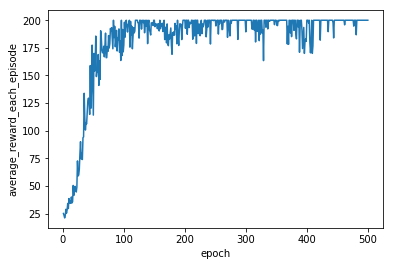

In [55]:

plt.plot(epoch_1, average_reward)
plt.xlabel('epoch')
plt.ylabel('average_reward_each_episode')

# Pong game

In [53]:
# set the environment of the game
import gym
env = gym.make('Pong-v0')

env.action_space.n
env.unwrapped.get_action_meanings()

# our agents only care about left and right move
Right_ACTION = 2
Left_ACTION = 3
action_dict = { 0:Right_ACTION, 1:Left_ACTION}
action_dict

{0: 2, 1: 3}

In [54]:


# set up the training hyperparameters

state_size = [80,80,1] # our input an image
action_size = 2  # number of actions (push to left or push to right)
#action_size = 1  # number of actions (push to left or push to right)
# training hyperparameters
learning_rate = 0.0001

number_epoch = 10000 # number of epochs for training
batch_size = 100 # defines number of samples work though
hidden_size_1 = 53
hidden_size_2 = 34

training = True 


max_steps = 200 # Max steps per episode




In [55]:
# calculate the discounted some of reward from current step onward
def discount_rewards(r, gamma = 0.99, constant_baseline = False):
    discounted_r = np.zeros_like(r) #make a vector of zeros with the size of input
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    if constant_baseline: # do normalization for reward to have more smooth gradient
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean)/(std)
        
    return discounted_r


In [56]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [65]:
# define the policy network 

class PGNetwork():
    def __init__(self, state_size, action_size, learning_rate, hidden_size_1, hidden_size_2, name = 'PGNetwork'):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        #self.hidden_size_1 = hidden_size_1
        self.hidden_size_1 = 53
        self.hidden_size_2 = 34
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, *state_size], name = 'inputs')
                self.actions = tf.placeholder(tf.int32, shape = [None, action_size], name = 'actions')
                #self.actions = tf.placeholder(tf.float32, shape = [None, action_size], name = 'actions')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
            # CNN is often used for image process
            #with tf.name_scope('conv_layer1'):
              
                # filters gives the number of filters in the convolution nn
            #    self.conv1 = tf.layers.conv2d(inputs = self.inputs,
            #                    filters = 32,
            #                    kernel_size = [3,3],
            #                    strides = [1,1],
            #                    padding = 'VALID',
            #                    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), name = 'conv1')
                
            #    self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1, training = True,
            #                                                epsilon = 1e-5, name = 'batch_norm1')
            #    
            #    self.conv1_out = tf.nn.relu(self.conv1_batchnorm, name = 'conv1_out')
            
                
            with tf.name_scope('layer1'):
                # filters gives the number of filters in the hidden nn
                #self.flatten = tf.contrib.layers.flatten(self.conv1_out)
                self.flatten = tf.contrib.layers.flatten(self.inputs)
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.flatten,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
            with tf.name_scope('layer2'):
                # filters gives the number of filters in the hidden nn
                self.layer2 = tf.contrib.layers.fully_connected(inputs = self.layer1,
                                             num_outputs = self.hidden_size_2,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                       
                                          
            with tf.name_scope('logits'):
                # get the action distribution from the fully connected NN
                self.logits = tf.layers.dense(inputs = self.layer2,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.action_size, 
                                             # units = 1, 
                                             activation = None)
            
               
                #self.out = tf.sigmoid(self.logits, name="sigmoid")
                
            with tf.name_scope('softmax'):
                self.action_distribution = tf.nn.softmax(self.logits)
                
            # define the loss function
            with tf.name_scope('loss'):
                #self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits( labels = self.actions,logits = self.logits)
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions)
                #self.log_action_probability = tf.nn.softmax_cross_entropy_with_logits(logits = self.outputlayer, labels = self.actions)
                self.weighted_likelihoods = tf.multiply(self.cross_entropy, self.discounted_episode_rewards)
                self.loss = tf.reduce_mean(self.weighted_likelihoods)

            with tf.name_scope('train'):
                #self.optimizer = tf.train.RMSPropOptimizer(1e-3, decay = 0.99)
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate,  beta1=0.9, beta2=0.99)
                self.train_opt = self.optimizer.minimize(self.loss)
            
            

In [66]:
# Value estimator network
class VENetwork():
    def __init__(self, state_size, learning_rate,  name = 'VENetwork'):
        
        self.state_size = state_size
        self.output_size = 1
        self.learning_rate = learning_rate
        self.hidden_size_1 = 64
        #self.hidden_size_2 = hidden_size_2
     
        
        # generate a network such that with a given state, the policy gives an action
        with tf.variable_scope(name):
            with tf.name_scope('inputs'):
            # we create placeholder
                self.inputs = tf.placeholder(tf.float32, shape = [None, *state_size], name = 'inputs')
                self.discounted_episode_rewards = tf.placeholder(tf.float32, shape = [None, ], name = 'discounted_episode_rewards')
                
            #  we use general fully connected layers
            with tf.name_scope('layer1'):
              
                self.inputs1 = tf.contrib.layers.flatten(self.inputs)
                # filters gives the number of filters in the convolution nn
                self.layer1 = tf.contrib.layers.fully_connected(inputs = self.inputs1,
                                             num_outputs = self.hidden_size_1,
                                             activation_fn = tf.nn.elu,
                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                                        
            with tf.name_scope('output'):
                # get the action distribution from the fully connected NN
                self.output_layer = tf.layers.dense(inputs = self.layer1,
                                             kernel_initializer = tf.contrib.layers.xavier_initializer(),      
                                             units = self.output_size, 
                                             activation = None)
                
                self.state_value_estimation = tf.squeeze(self.output_layer)
                
            # define the loss function
            with tf.name_scope('loss'):

                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards))
                
           
                
            with tf.name_scope('train'):
                #self.optimizer = tf.train.RMSPropOptimizer(1e-3, decay = 0.99)
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)

In [67]:
# sample from the environment 
# initialize network and session
tf.reset_default_graph()
PGN = PGNetwork(state_size, action_size, learning_rate,hidden_size_1, hidden_size_2)
VEN = VENetwork(state_size, learning_rate)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [68]:
# run the policy until it reached maximum batch number and outputs information of each step (batch number)
# for each episode
def make_batch(batch_size):
    states, actions, rewards_of_episode, rewards_of_batch, rewards_of_episode0, discounted_rewards = [],[],[], [], [],[]
    
    # keep track of how many episodes in our batch (useful when we need to calculate the average reward)
    episode_num = 1
    
    # get a new state
    state = env.reset()
    #state = preprocess(state)
    while True:
        state = preprocess(state)
        action_probability_distribution = sess.run(PGN.action_distribution, feed_dict = {PGN.inputs: state.reshape(1,*state_size)})
        #action_probability = sess.run(PGN.out, feed_dict = {PGN.inputs: state.reshape(1,*state_size)})
        #state_value_estimation = sess.run(VEN.state_value_estimation, feed_dict = {VEN.inputs: state.reshape(1,*state_size)})
        #action_probability = action_probability[0][0]
                                                                                      
        action = np.random.choice(range(action_probability_distribution.shape[1]), p = action_probability_distribution.ravel())
        #action = np.random.choice(range(2,4), p = [1-action_probability, action_probability])
        action_ = [0,0]
        action_[action] = 1
        
        action = action_dict[action]
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action_)
        rewards_of_episode.append(reward)
        #rewards_of_episode0.append(reward-state_value_estimation)
        
        if done:
            rewards_of_batch.append(rewards_of_episode)
            discounted_rewards.append(discount_rewards(rewards_of_episode, gamma = 0.99, constant_baseline = True))
            
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            rewards_of_episode = []
            rewards_of_episode0 = []
            episode_num +=1
            
            state = env.reset()
        else:
            state = next_state
    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num

    



In [69]:
# training and print sth
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
average_reward = []
epoch = 1
# for plotting
epoch_1 = []
average_reward = []
saver = tf.train.Saver()
# while we have epoch/episode to train

In [ ]:


if training:
    # number of iterations
    while epoch < number_epoch +1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size)
        
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        print('check',rewards_of_batch.shape, np.array(total_reward_of_that_batch).shape)
        allRewards.append(total_reward_of_that_batch)
        
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)
        maximumRewardRecorded = np.amax(allRewards)
        print('epoch',epoch)
        epoch_1.append(epoch)
        print('====================================')
        print("Epoch: ", epoch, '/', number_epoch)
        print('------------')
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward:{}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        loss_,cross, _= sess.run([PGN.loss, PGN.cross_entropy, PGN.train_opt],feed_dict = {PGN.inputs: states_mb.reshape([len(states_mb), *state_size]), PGN.actions: actions_mb,PGN.discounted_episode_rewards: discounted_rewards_mb})    
        #loss_VE, _= sess.run([VEN.loss, VEN.train_opt],feed_dict = {VEN.inputs: states_mb.reshape([len(states_mb), *state_size]), VEN.discounted_episode_rewards: discounted_rewards_mb})    

        print('check',total_reward_of_that_batch)
        print('Training loss:{}'.format(loss_) )
        #print('Cross Entropy:{}'.format(cross) )
        #print('VE Training loss:{}'.format(loss_VE) )
              
        if epoch % 50 == 0:
            saver.save(sess, "./models/model2.ckpt")
            print('Model saved')
            with open('mean_reward2.txt', 'w') as myFile:
                print('{}'.format(average_reward), file=myFile)
        epoch += 1
        average_reward.append(mean_reward_of_that_batch)

check (1354,) ()
epoch 1
Epoch:  1 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -21.0
Max reward for a batch so far: -21.0
check -21.0
Training loss:-2.5571713194949552e-05
check (1427,) ()
epoch 2
Epoch:  2 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -21.0
Max reward for a batch so far: -21.0
check -21.0
Training loss:0.002816486405208707
check (1322,) ()
epoch 3
Epoch:  3 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -21.0
Max reward for a batch so far: -21.0
check -21.0
Training loss:0.0008049574098549783
check (1516,) ()
epoch 4
Epoch:  4 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -20.5
Max reward for a batch so far: -19.0
che

check (1349,) ()
epoch 28
Epoch:  28 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.392857142857142
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.0015200593043118715
check (1589,) ()
epoch 29
Epoch:  29 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.413793103448278
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.00011994090164080262
check (1191,) ()
epoch 30
Epoch:  30 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.433333333333334
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.0032211279030889273
check (1275,) ()
epoch 31
Epoch:  31 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all train

check (2147,) ()
epoch 55
Epoch:  55 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -20.272727272727273
Max reward for a batch so far: -15.0
check -20.0
Training loss:0.0017003279644995928
check (1428,) ()
epoch 56
Epoch:  56 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.285714285714285
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.003849796252325177
check (1492,) ()
epoch 57
Epoch:  57 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.29824561403509
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.0010275956010445952
check (1353,) ()
epoch 58
Epoch:  58 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training:

check (1353,) ()
epoch 82
Epoch:  82 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -20.24390243902439
Max reward for a batch so far: -15.0
check -19.0
Training loss:-3.970611942349933e-05
check (1583,) ()
epoch 83
Epoch:  83 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.253012048192772
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.0019089945126324892
check (1552,) ()
epoch 84
Epoch:  84 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -20.25
Max reward for a batch so far: -15.0
check -20.0
Training loss:-0.009283862076699734
check (1462,) ()
epoch 85
Epoch:  85 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -20.247058

check (1925,) ()
epoch 109
Epoch:  109 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -20.201834862385322
Max reward for a batch so far: -15.0
check -19.0
Training loss:0.0005045071011409163
check (1588,) ()
epoch 110
Epoch:  110 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.20909090909091
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.001050771214067936
check (1588,) ()
epoch 111
Epoch:  111 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.216216216216218
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.0043388912454247475
check (1842,) ()
epoch 112
Epoch:  112 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all 

check (1901,) ()
epoch 136
Epoch:  136 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.139705882352942
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.006101552862673998
check (1439,) ()
epoch 137
Epoch:  137 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.145985401459853
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.010783376172184944
check (1561,) ()
epoch 138
Epoch:  138 / 10000
------------
Number of training episodes: 1
Total reward:-18.0
Mean Reward of that batch -18.0
Average Reward of all training: -20.130434782608695
Max reward for a batch so far: -15.0
check -18.0
Training loss:-0.0033890176564455032
check (1780,) ()
epoch 139
Epoch:  139 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of al

check (2459,) ()
epoch 162
Epoch:  162 / 10000
------------
Number of training episodes: 1
Total reward:-16.0
Mean Reward of that batch -16.0
Average Reward of all training: -20.049382716049383
Max reward for a batch so far: -15.0
check -16.0
Training loss:-0.00017795624444261193
check (1596,) ()
epoch 163
Epoch:  163 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.05521472392638
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.006633633282035589
check (1727,) ()
epoch 164
Epoch:  164 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.0609756097561
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.005825598258525133
check (1685,) ()
epoch 165
Epoch:  165 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all 

check (1646,) ()
epoch 188
Epoch:  188 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -20.02659574468085
Max reward for a batch so far: -15.0
check -20.0
Training loss:-0.017741849645972252
check (1924,) ()
epoch 189
Epoch:  189 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.03174603174603
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.021157171577215195
check (1403,) ()
epoch 190
Epoch:  190 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -20.03684210526316
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.00945881474763155
check (2072,) ()
epoch 191
Epoch:  191 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all tra

check (1929,) ()
epoch 215
Epoch:  215 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -19.94418604651163
Max reward for a batch so far: -15.0
check -20.0
Training loss:0.0059195104986429214
check (2035,) ()
epoch 216
Epoch:  216 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -19.944444444444443
Max reward for a batch so far: -15.0
check -20.0
Training loss:-0.0038395302835851908
check (1911,) ()
epoch 217
Epoch:  217 / 10000
------------
Number of training episodes: 1
Total reward:-17.0
Mean Reward of that batch -17.0
Average Reward of all training: -19.930875576036865
Max reward for a batch so far: -15.0
check -17.0
Training loss:-0.011540875770151615
check (1889,) ()
epoch 218
Epoch:  218 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all

check (1949,) ()
epoch 242
Epoch:  242 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all training: -19.867768595041323
Max reward for a batch so far: -15.0
check -20.0
Training loss:-0.006432111840695143
check (1599,) ()
epoch 243
Epoch:  243 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -19.872427983539094
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.012854065746068954
check (2012,) ()
epoch 244
Epoch:  244 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -19.868852459016395
Max reward for a batch so far: -15.0
check -19.0
Training loss:-0.01517198421061039
check (1781,) ()
epoch 245
Epoch:  245 / 10000
------------
Number of training episodes: 1
Total reward:-20.0
Mean Reward of that batch -20.0
Average Reward of all 

check (2229,) ()
epoch 268
Epoch:  268 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -19.80597014925373
Max reward for a batch so far: -15.0
check -21.0
Training loss:0.0002413116890238598
check (2084,) ()
epoch 269
Epoch:  269 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -19.802973977695167
Max reward for a batch so far: -15.0
check -19.0
Training loss:-0.010626292787492275
check (1977,) ()
epoch 270
Epoch:  270 / 10000
------------
Number of training episodes: 1
Total reward:-21.0
Mean Reward of that batch -21.0
Average Reward of all training: -19.807407407407407
Max reward for a batch so far: -15.0
check -21.0
Training loss:-0.0006981996120885015
check (2583,) ()
epoch 271
Epoch:  271 / 10000
------------
Number of training episodes: 1
Total reward:-15.0
Mean Reward of that batch -15.0
Average Reward of all

check (2233,) ()
epoch 294
Epoch:  294 / 10000
------------
Number of training episodes: 1
Total reward:-18.0
Mean Reward of that batch -18.0
Average Reward of all training: -19.700680272108844
Max reward for a batch so far: -15.0
check -18.0
Training loss:-0.0004645741428248584
check (2480,) ()
epoch 295
Epoch:  295 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -19.698305084745762
Max reward for a batch so far: -15.0
check -19.0
Training loss:-0.000412762543419376
check (2323,) ()
epoch 296
Epoch:  296 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of all training: -19.695945945945947
Max reward for a batch so far: -15.0
check -19.0
Training loss:0.00043820985592901707
check (2230,) ()
epoch 297
Epoch:  297 / 10000
------------
Number of training episodes: 1
Total reward:-19.0
Mean Reward of that batch -19.0
Average Reward of a

Text(0,0.5,'average_reward_each_episode')

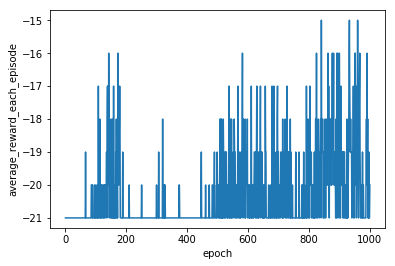

In [58]:
plt.plot(epoch_1[:1000], average_reward[:1000])
plt.xlabel('epoch')
plt.ylabel('average_reward_each_episode')

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "./models/model.ckpt")

Personal commnent on the second problem: 
It is hard to train the Pong game (adjust its hyperparameters to get the convergence result), because its state_size is large. The above figure is what I got with constant baseline and learning rate 1e-3. The line goes up and down means the model is at least learning. It does not lead to convergence result may be because the hyperparameters and the models I tried are not very well. Training the Pong game needs to do a lot of experiments, and the above result is the best I got, even though it does not lead to convergence. My number of epoch is set to be 10000, but I only plotted the first 1000 result because I did not finish training. 